# Exploring Explainable AI: Training Image Models and Interpreting Predictions with LIME and Grad-CAM


## Introduction

In this lab, we will explore the field of Explainable AI (XAI) by training an image classification model and interpreting its predictions using two popular XAI techniques: **LIME** (Local Interpretable Model-agnostic Explanations) and **Grad-CAM** (Gradient-weighted Class Activation Mapping).

### Objectives:
- Train an image classification model using a standard dataset (e.g., CIFAR-10 or FashionMNIST).
- Apply LIME to explain individual predictions made by the model.
- Visualize the model’s decision-making process using Grad-CAM.

By the end of this lab, you will gain hands-on experience in understanding and interpreting the workings of machine learning models, enhancing transparency and trust in AI systems.


### Installing Required Libraries

In this step, we will install the necessary Python libraries for the lab. Specifically, we will install **LIME**, which is a library used for generating interpretable explanations of machine learning model predictions. LIME helps to approximate the behavior of a complex model locally, by fitting simple, interpretable models to its predictions.

The following code installs the `lime` package:


In [1]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=ac87db200ba96c9ba7e20220dd8549697c7993df88e2738ff1da7eb76f58915a
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


### Importing Libraries

In this section, we will import the necessary libraries for the lab. These libraries provide the tools for data manipulation, model training, and interpretation. Here's a breakdown of the key imports:

- **`warnings`**: Used to suppress warnings that might clutter the output.
- **`pandas` and `numpy`**: Essential libraries for data manipulation and numerical computations.
- **`lime` and its submodules**: The core package used for generating interpretable explanations, including `lime.lime_tabular` for tabular data, `LimeTextExplainer` for text, and `submodular_pick` for more advanced picking strategies.
- **`matplotlib`**: A plotting library used for visualizing results.
- **`sklearn`**: A library for machine learning, providing tools for data splitting, model training, and evaluation.

We also set a random seed with **`np.random.seed(123)`** to ensure reproducibility of results across runs.

The following code imports these libraries and prepares the environment for the next steps in the lab.


In [15]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import lime
from lime import lime_image
from lime import submodular_pick
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input, decode_predictions

np.random.seed(123)

### Mounting Google Drive and Setting Working Directory

In this section, we mount Google Drive to access files stored there. This is especially useful if you're working in Google Colab, where your datasets and code can be saved and accessed from your Google Drive.

The code does the following:
1. **Mounts Google Drive** to the Colab environment.
2. Changes the working directory to the specific folder where your Assignemet 9 files are located.
3. Lists the files in the folder to confirm the contents.

Now, you can easily access your lab materials directly from Google Drive.


In [3]:
from google.colab import drive
drive.mount('/content/drive')


import os
os.chdir('/content/drive/My Drive/XAI_Lab')
folder = os.path.join('/content/drive/My Drive/XAI_Lab')
!ls

Mounted at /content/drive
 1Phh6hv.jpeg   1.png   2.png   3.png   5.png  'XAI Lab.ipynb'


LIME
Here’s what you need to know about LIME:

- LIME stands for local interpretable model-agnostic explanations. It is a post hoc, perturbation-based explainability technique.

- LIME can be used for regression or classification models, though in practice LIME is used primarily for classification models.

- LIME works by changing regions of an image, turning them on or off and re­running inferences to see which regions are most influential to the model’s prediction.

- LIME uses an inherently interpretable model to measure influence or importance of input features.

**How LIME Works**

LIME is a post hoc, model-agnostic, perturbation-based explainability technique. That means it can be applied to any machine learning model (e.g., neural networks, SVM, random forest, etc.) and is applied after the model has been trained. In essence, LIME treats the trained model like an API, taking an example instance and producing a prediction value. To explain why the model makes a certain prediction for a given input instance, the LIME algorithm works by passing lots and lots of slightly perturbed examples of the original input to the model and then measures how the model predictions change with these small input changes. The perturbations occur at the feature level of the input instance; i.e., images, pixels, and pixel regions are modified to create a new perturbed input. In this way, those pixels or pixel regions that most influence the model’s prediction are highlighted as being more or less influential to the model’s predicted output for the given input instance.

To go into a little more detail, let’s further explain two of the key components of implementing LIME: first, how to generate a perturbation of an image and second, what it means to measure how the model prediction changes on these perturbations.

For a given prediction, the input image is subdivided into interpretable components, or regions, of the image. LIME segments the image into regions called superpixels. A superpixel is a similarity-based grouping of the individual pixels of an image into similar components (see the discussion of Felzenszwalb’s algorithm in the earlier section “XRAI”). For example, Figure below shows how the image of the sulfur-crested cockatoo can be segmented into superpixels. The superpixel regions represent the interpretable components of the image.

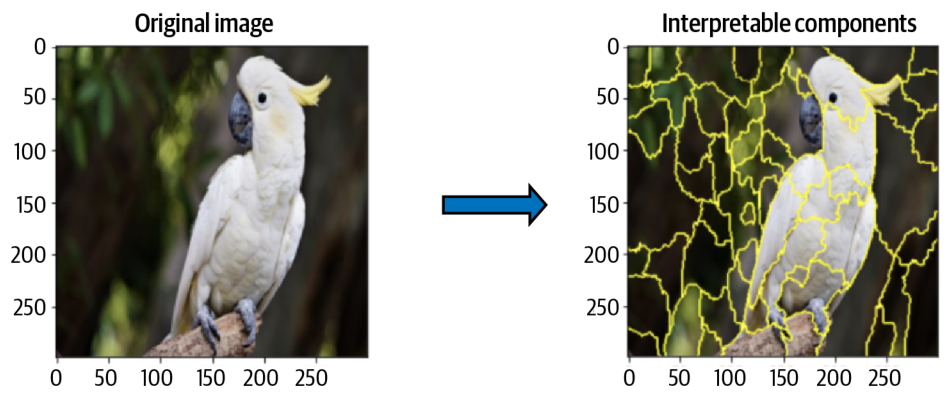

In [4]:
plt.figure(figsize=(12,8))
img=plt.imread('/content/drive/My Drive/XAI_Lab/1.png')
plt.imshow(img)
plt.axis('off')
plt.show()

The superpixel regions in the Figure were created using the quickshift segmentation algorithm from the scikit-image library. This is the default segmentation algorithm used in the widely used, open source Python package LIME (see the next section, “Implementing LIME”), although other segmentation functions could be used. Quickshift is based on an approximation of kernelized mean-shift and computes hierarchical segmentation at multiple scales simultaneously. Quickshift has two main parameters: the parameter sigma determines the scale of the local density approximation, and max_dist determines the level of the hierarchical segmentation. There is also a parameter ratio that controls the ratio between the distance in color space and the distance in image space when comparing the similarity of two pixels. The following code produces the segmentation in Figure 4-23. See the LIME notebook in the GitHub repository for this book for the full code example:



In [5]:
from skimage.segmentation import quickshift

segments = quickshift(img, kernel_size=4,
                      max_dist=200, ratio=0.2)

LIME then perturbs these interpretable components by changing the values of the pixels in each superpixel region to be gray. This creates multiple new variations, or perturbations, of the input image. Each of these new perturbed instances is then given to the model to generate new prediction values for the class that was originally predicted. For example, in the followin Figure the original image is modified by graying out certain superpixel regions. Those perturbed examples are then passed to the trained model (in this case a deep neural network), and the model returns the probability that the image contains a sulfur-crested cockatoo. These new predictions create a dataset that is used to train LIME’s linear model to determine how much each interpretable component contributes to the original prediction.



In [ ]:
plt.figure(figsize=(12,8))
img=plt.imread('/content/drive/My Drive/XAI_Lab/2.png')
plt.imshow(img)
plt.axis('off')
plt.show()

In the LIME implementation, superpixels are turned “on” or “off” by changing the pixel values of a segment to gray. This creates a collection of perturbed images that are passed to the model for prediction. It is also possible to instead change the superpixel regions to the mean of the individual pixel values in the superpixel region, as shown in Figure 4-25.



In [ ]:
plt.figure(figsize=(12,8))
img=plt.imread('/content/drive/My Drive/XAI_Lab/3.png')
plt.imshow(img)
plt.axis('off')
plt.show()

Let’s now discuss how LIME quantitatively measures the contributions of the superpixel feature inputs. This is done by training a smaller, interpretable model to provide explanations for the original model. This smaller model can be anything, but the important aspect is that it is inherently interpretable. In the original paper,7 the authors use the example of a linear model. Linear models are inherently interpretable because the weights of each feature directly indicate the importance of that feature for the model’s prediction.

This interpretable, linear model is then trained on a dataset consisting of the perturbed examples and the original model’s predictions, as shown in the eralier Figure. These perturbations are really just simple binary representations of the image indicating the “presence” or “absence” of each superpixel region. Since we care about the perturbations that are closest to the original image, those examples with the most superpixels present are weighted more than examples that have more superpixels absent. This proximity can be measured using any distance metric for images. The idea is that even though your trained model might be highly complex, for example a deep neural network or an SVM, the locally weighted, linear model can capture the local behavior at a given input instance. The more sensitive the complex model is to a given input feature, the more of an influence that feature will have on the linear, interpretable model as well.



### Implementing LIME

Now, we will be applying LIME for explaining CNN models

Since we are more interested to check how black-box image classifiers can be explained using LIME, we will focus only on the inference part. Let us load any generic image data. For this example, we will take the data from this source: https://i.imgur.com/1Phh6hv.jpeg

### Loading and Displaying an Image

In this section, we load and display an image from a specified file path. The code does the following:
1. **Image Path**: Specifies the path where the image is stored (in this case, on Google Drive).
2. **Read Image**: Uses `mpimg.imread()` to read the image from the given path.
3. **Display Image**: `plt.imshow()` is used to display the image in the notebook, and `plt.axis('off')` is used to hide the axis for better visualization.

This allows us to visualize the image that we will be working with in the next steps of the lab.


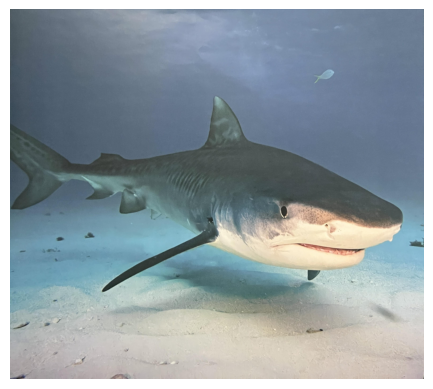

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Specify the path to your image
image_path = '/content/drive/My Drive/XAI_Lab/1Phh6hv.jpeg'

# Read the image
img = mpimg.imread(image_path)

# Display the image
plt.imshow(img)
plt.axis('off')  # Turn off axis
plt.show()

### Image Preprocessing for Xception Model

Before feeding an image into the Xception model (the model we are going to use later), it must be preprocessed to match the expected input format. This step involves resizing the image, normalizing it, and converting it to a batch-compatible format. Here's how the code works:

1. **Set Image Size**: The target input size for the Xception model is `(299, 299)`. This is the shape of the image that the model expects.
2. **Transform Image**: The function `transform_image()` performs the following:
   - **Resize**: The image is resized to the target size using `image.load_img()`.
   - **Convert to Array**: The image is then converted to a numpy array using `image.img_to_array()`.
   - **Batch Format**: We add a new dimension to the image using `np.expand_dims()` to make it compatible with the model's input shape. This turns the image into a batch of size `(1, 299, 299, 3)`, as the model expects a batch even when processing a single image.
   - **Normalization**: The image pixel values are normalized by dividing by 255.0 to scale the values to the range of 0 to 1, which is the expected range for the Xception model.
   
After running this function, the image is ready for prediction.

The following code normalizes the image located at `image_path` to match the input requirements of the Xception model.


In [11]:
IMG_SIZE = (299, 299) #This is the shape of the input for the Xception model
def transform_image(image_path, size):
    '''
    Function to transform an image to normalized numpy array
    '''
    img = image.load_img(image_path, target_size=size)
    img = image.img_to_array(img)# Transforming the image to get the shape as [channel, height, width]
    img = np.expand_dims(img, axis=0) # Adding dimension to convert array into a batch of size (1,299,299,3)
    img = img/255.0 # normalizing the image to keep within the range of 0.0 to 1.0

    return img

normalized_img = transform_image(image_path, IMG_SIZE)

### Defining the model

For this example, we are not training a model from scratch, but rather defining a pretrained Tensorflow Xception model as our black-box Deep Learning model which we will be explaining using the LIME framework.


Xception, short for Extreme Inception, is a deep learning model that uses depthwise separable convolution layers to classify images.
Xception is a convolutional neural network (CNN) with 71 layers. It uses depthwise separable convolution layers instead of inception modules, which are used in the Inception architecture. Maybe this one is something you want to study in your assignment ? :)

### Defining the Xception Model and Making Predictions

In this section, we define the **Xception** model, a pre-trained deep learning model designed for image classification tasks. This model is trained on the **ImageNet** dataset, which contains a wide variety of images. The pre-trained weights are loaded by setting `weights="imagenet"`.

The following steps occur:
1. **Model Definition**: The Xception model is loaded with pre-trained weights from ImageNet.
2. **Prediction Function**: We define a function `get_model_predictions` to make predictions using the model. This function:
   - Takes an image input (`data`).
   - Uses the model to predict the class of the image.
   - Prints and returns the top predicted class.
3. **Prediction**: Finally, we use the function to predict the class of an image (`normalized_img[0]`) and display the result.

The `plt.imshow()` function is used to display the image, while `decode_predictions()` interprets the raw output from the model into human-readable class names.


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
The predicted class is : tiger_shark


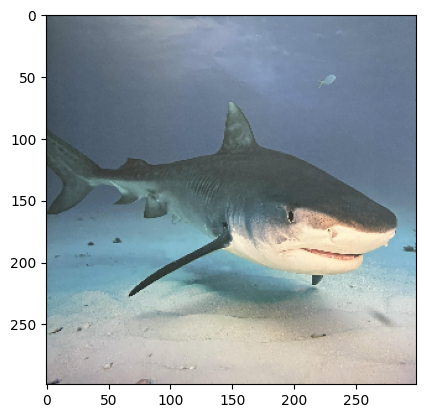

In [16]:
model = Xception(weights="imagenet")

def get_model_predictions(data):
    model_prediction = model.predict(data)
    print(f"The predicted class is : {decode_predictions(model_prediction, top=1)[0][0][1]}")
    return decode_predictions(model_prediction, top=1)[0][0][1]

plt.imshow(normalized_img[0])
pred_orig = get_model_predictions(normalized_img)

### Exploring the Architecture of the Xception Model

In this section, you will explore the structure of the Xception model. You’ll start by displaying the model summary, which gives a textual overview of the layers, and then move on to visualizing the model architecture graphically using external libraries.

#### 1. Model Summary
The `summary()` method provides a detailed textual summary of the model. This includes:
- The name of each layer
- The type of each layer (e.g., convolutional, dense, etc.)
- The output shape of each layer
- The number of parameters in each layer

#### 2. Plotting the Model Architecture
You can also visualize the model's architecture using the **`Visualkeras`** library, which provides a clear, graphical representation of the model. Alternatively, you can use Keras' built-in **`plot_model()`** function to generate a diagram of the network.

##### Steps:
1. **Display the model summary** using `model.summary()`.
2. **Visualize the model architecture** using **`Visualkeras`** or **`plot_model()`**.

Here's the code to perform these tasks:


In [17]:
from tensorflow.keras.utils import plot_model

# 1. Display the summary of the model
model.summary()



Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 299, 299, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 149, 149, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 149, 149, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 149, 149, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 147, 147, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 147, 147, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 147, 147, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 147, 147, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 147, 147, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 147, 147, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 74, 74, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 74, 74, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 22,910,480 (87.40 MB)

 Trainable params: 22,855,952 (87.19 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [18]:
!pip install visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 11.1 MB/s eta 0:00:00


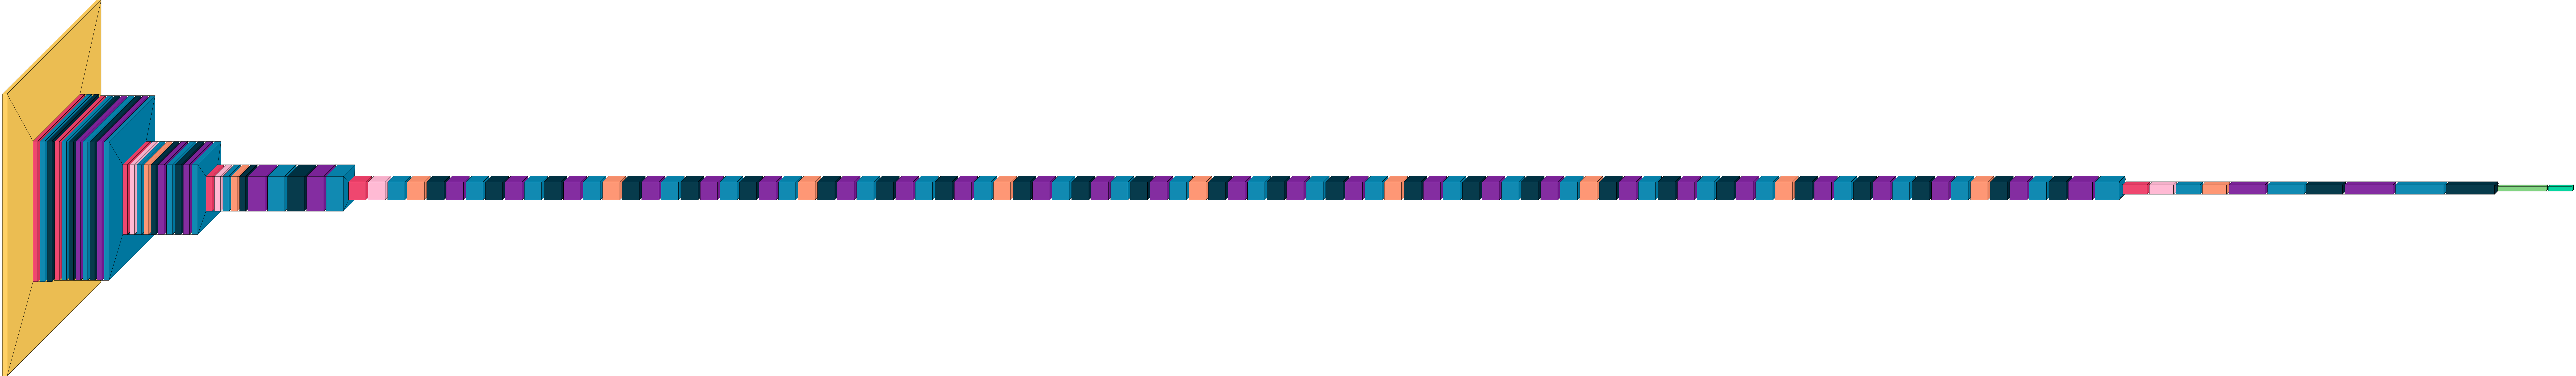

In [19]:
import visualkeras

# 2. Visualizing the model architecture using Visualkeras
visualkeras.layered_view(model)

Play more with visualisation of your model following this link: https://pypi.org/project/visualkeras/

In [ ]:
# Try different visualisations of the Xception model

As image is predicted as *Tiger Shark* which is the correct prediction and the black-box model is successfully able to give the correct prediction. Now, let us even take a look at the top 5 predictions along with the model confidences.

In [20]:
model_prediction = model.predict(normalized_img)
top5_pred = decode_predictions(model_prediction, top=5)[0]
for pred in top5_pred:
    print(pred[1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step
tiger_shark
great_white_shark
hammerhead
scuba_diver
sturgeon


As we see, although the model is well trained to produce the correct prediction, but there are chances that the model is not just looking into main object in the image but as well as the surrounding background. This is evident from the prediction of *scuba_driver* present in the top 5 prediction list. So, it is important for us understand, the key components or parts of the image the model is looking into to make the prediction.

### Implementing LIME for Image Explanations


In this step, you will use LIME (Local Interpretable Model-Agnostic Explanations) to explain the predictions made by the Xception model. LIME helps us understand how the model makes decisions for individual predictions by approximating the model locally with an interpretable surrogate model.

The LimeImageExplainer class from the lime library provides methods for explaining the predictions of image classification models.

Steps:

- Initialize the Explainer: You will initialize the LimeImageExplainer class, which is designed for image data.
- Explain a Prediction: Using the explainer, you can generate an explanation for a specific prediction made by the Xception model.

This line of code initializes the LIME Image Explainer for generating explanations for image-based predictions. The explainer will later be used to interpret the model’s predictions by highlighting the regions in the image that most influenced the model's output.

In [21]:
# Initialize the LIME image explainer
explainer = lime_image.LimeImageExplainer()

# Generate explanation for the given image
exp = explainer.explain_instance(
    normalized_img[0],            # The image for which you want to explain the prediction
    model.predict,                 # The model's prediction function
    top_labels=5,                  # Number of top predicted labels to consider
    hide_color=0,                  # Don't hide any colors in the explanation
    num_samples=1000               # Number of random perturbations to use for explanation
)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3

### Detailed Explanation of Each Line of Code

1. **`explainer = lime_image.LimeImageExplainer()`**:
   - **Purpose**: This line creates an instance of the `LimeImageExplainer` class from the LIME library. The explainer is specifically designed for image classification models.
   - **How it works**: The `LimeImageExplainer` will approximate the model’s behavior using interpretable, simpler models in the local region around the input image. By perturbing the image (making small random changes), LIME identifies the most important parts of the image for the model’s prediction.

2. **`exp = explainer.explain_instance(...)`**:
   - **Purpose**: This function generates an explanation for the prediction made by the model for a specific image.
   - **Parameters**:
     - **`normalized_img[0]`**: This is the input image for which we want to generate an explanation. The image has been preprocessed (normalized) earlier in the code to ensure it fits the input requirements of the Xception model. It’s selected as the first image in the batch `normalized_img`.
     - **`model.predict`**: This is the model's prediction function (in this case, the Xception model). This function takes an image and returns the model's predicted class probabilities.
     - **`top_labels=5`**: This parameter tells LIME to generate explanations for the top 5 predicted labels (i.e., the five most probable classes the model predicts for this image). By default, it would generate an explanation for the most likely label, but we can choose to explore the top 5 for more insight.
     - **`hide_color=0`**: This parameter ensures that no colors in the image are hidden in the explanation. Setting it to `0` means that all parts of the image are included in the explanation.
     - **`num_samples=1000`**: This specifies the number of perturbed versions (random variations) of the input image that LIME will generate in order to approximate the model’s decision boundary. More samples result in more accurate explanations, but at the cost of more computational resources.

### What Happens Next:
Once this line of code is executed, the variable `exp` will contain the explanation object. This object includes information about how different parts of the image influenced the model's prediction. The explanation will help us understand which image features the model considered most important for its decision.


Our explainer object is ready, but let us visualize the various explanation segments created by the LIME algorithm.


In LIME, when displaying the "explanation.segments" for an image, different colors are used to represent different segments or superpixels. Each color corresponds to a different segment or superpixel within the image.

This color-coding serves two main purposes:

1. Segment Differentiation: By assigning different colors to different segments, LIME visually distinguishes between the various parts of the image that are being highlighted for their importance in the model's prediction. This helps viewers easily identify and differentiate between different segments within the image.

2. Visual Representation of Importance: The choice of colors can also convey additional information about the importance or contribution of each segment to the model's prediction. For example, brighter or more saturated colors may indicate segments that have a higher impact on the model's decision, while darker or less saturated colors may represent segments with lower importance.



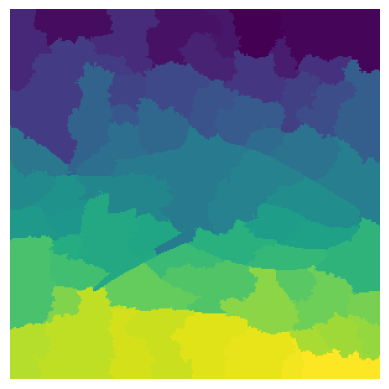

In [31]:
plt.imshow(exp.segments)
plt.axis('off')
plt.show()

Now, let us use the top segments or super pixels to identify the region of interest of the image used by the model to make its prediction.

In [32]:
def generate_prediction_sample(exp, exp_class, weight = 0.1, show_positive = True, hide_background = True):
    '''
    Method to display and highlight super-pixels used by the black-box model to make predictions
    '''
    image, mask = exp.get_image_and_mask(exp_class,
                                         positive_only=show_positive,
                                         num_features=6,
                                         hide_rest=hide_background,
                                         min_weight=weight
                                        )
    plt.imshow(mark_boundaries(image, mask))
    plt.axis('off')
    plt.show()

### Detailed Explanation of Each Line of Code:

1. **`def generate_prediction_sample(exp, exp_class, weight = 0.1, show_positive = True, hide_background = True):`**
   - **Purpose**: This line defines the `generate_prediction_sample` function, which takes in the explanation object, predicted class, and additional parameters to display and highlight super-pixels used by the model to make its prediction.
   - **Parameters**:
     - `exp`: The explanation object that contains the details of the image explanation from LIME.
     - `exp_class`: The predicted class for which we want the explanation.
     - `weight`: Controls the minimum weight of features (super-pixels) to be included in the explanation.
     - `show_positive`: A boolean parameter that decides whether only positive contributions to the model’s prediction should be shown.
     - `hide_background`: A boolean parameter that controls whether the background should be hidden in the explanation.
   
2. **`image, mask = exp.get_image_and_mask(...)`**
   - **Purpose**: This line retrieves the transformed image (`image`) and the explanation mask (`mask`) using the `get_image_and_mask` method of the `exp` object.
   - **Parameters**:
     - `exp_class`: The predicted class for which the explanation is being generated.
     - `positive_only=show_positive`: If `True`, only the positive contributions to the model's prediction will be highlighted.
     - `num_features=6`: Specifies that 6 super-pixels (features) should be displayed in the explanation.
     - `hide_rest=hide_background`: If `True`, parts of the image that are not significant for the prediction will be hidden.
     - `min_weight=weight`: Specifies the minimum weight for the features to be shown in the explanation.

3. **`plt.imshow(mark_boundaries(image, mask))`**
   - **Purpose**: This line displays the image using `matplotlib` and overlays the super-pixel boundaries over the image using `mark_boundaries()`.
   - **Parameters**:
     - `image`: The transformed image from LIME that will be displayed.
     - `mask`: The explanation mask that highlights the regions of the image that contributed the most to the prediction.

4. **`plt.axis('off')`**
   - **Purpose**: This line removes the axis labels and ticks from the image plot, so the image itself is the main focus, without distractions from axis information.

5. **`plt.show()`**
   - **Purpose**: This line displays the final image with the highlighted super-pixels and removed axis, allowing for a clean and clear visualization of the important image regions.


### Using the `generate_prediction_sample` Function

Now, we will use the `generate_prediction_sample` function to visualize the explanation for the predicted class of the image.

We will pass the explanation object `exp`, the top predicted class `exp.top_labels[0]`, and set the parameters `show_positive = True` and `hide_background = False`. This means we will highlight the positive contributions to the prediction and keep the background visible.


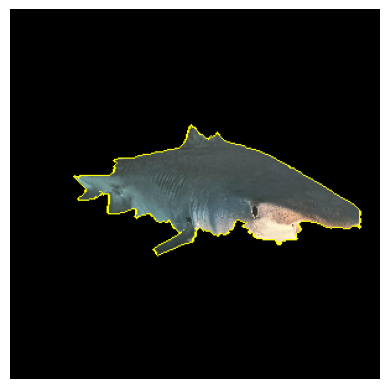

In [33]:
generate_prediction_sample(exp, exp.top_labels[0], show_positive = True, hide_background = True)



As we can see from the above image that the model was able to identify the correct region, which does indicate the correct prediction of the outcome by the model.

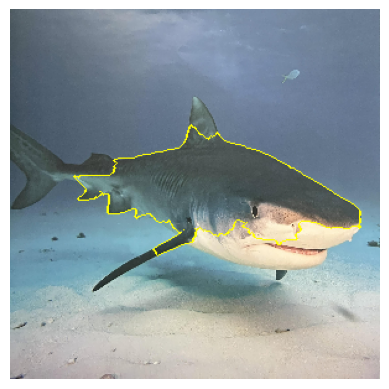

In [34]:
generate_prediction_sample(exp, exp.top_labels[0], show_positive = True, hide_background = False)

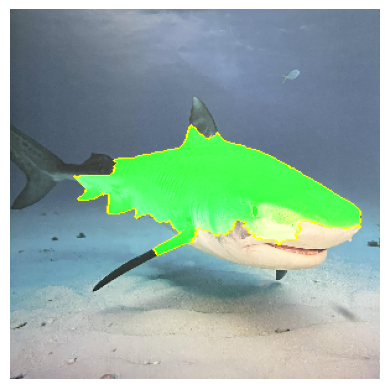

In [35]:
generate_prediction_sample(exp, exp.top_labels[0], show_positive = False, hide_background = False)

The above samples show us how we can hide or show the background along with the super-pixels or even outline or highlight the super-pixels to identify the region of interest used by the model to make the prediction. What we see from here does make sense, and does allow us to increase trust towards black-box models. We can also form a heat-map to show how important each super-pixel is to get some more granular explaianbility.

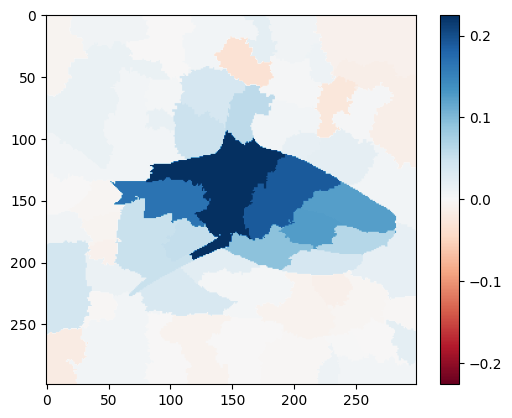

In [36]:
def explanation_heatmap(exp, exp_class):
    '''
    Using heat-map to highlight the importance of each super-pixel for the model prediction
    '''
    dict_heatmap = dict(exp.local_exp[exp_class])
    heatmap = np.vectorize(dict_heatmap.get)(exp.segments)
    plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
    plt.colorbar()
    plt.show()

explanation_heatmap(exp, exp.top_labels[0])

We can clearly identify the most influential segments used by the model to make the prediction using this heatmap visualization.

Now, let try to perform the same steps for another explanation class and see if the results are different.

In [37]:
index = 2
print(f"We will deal with predicted class: {top5_pred[index][1]}")

We will deal with predicted class: hammerhead


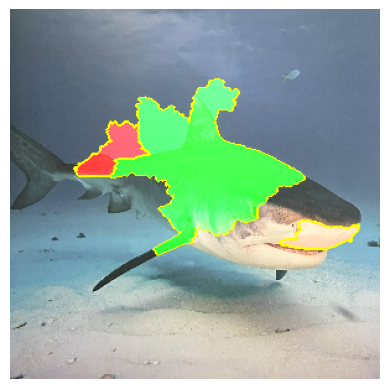

In [38]:
generate_prediction_sample(exp, exp.top_labels[index], weight = 0.0001, show_positive = False, hide_background = False)

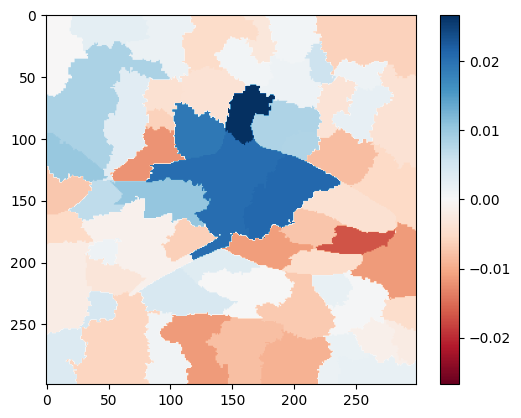

In [39]:
explanation_heatmap(exp, exp.top_labels[index])

### Your Turn: Perform LIME on Another Image

Now it's your turn! Follow the steps below to apply LIME on a new image of your choice. You can choose any image from the internet. Here’s what you need to do:

1. **Get an image**: Find an image online that you would like to analyze. Download the image to your local environment or upload it to your Colab notebook.

2. **Load and preprocess the image**: Use the `transform_image` function to load and preprocess the image to the required input shape for the Xception model.

3. **Generate explanation with LIME**: Use the `LIME` explainer (`lime_image.LimeImageExplainer()`) to generate an explanation for the new image.

4. **Visualize the explanation**: Use the `generate_prediction_sample()` function to display the super-pixels that contributed to the prediction for the image.

### Steps:
- Load the image and preprocess it as you've done before.
- Use `model.predict()` to predict the class of the image.
- Generate a LIME explanation using the `explainer.explain_instance()` method.
- Visualize the explanation using `generate_prediction_sample()`.

### Expected Output:
You should be able to visualize which areas of your image contributed to the model's prediction, just as we did in the previous steps. Remember to adjust the parameters to show positive contributions or hide the ba


In [ ]:
# Your code is here.
#
#
# #
#
#
#
#
#
#
#
#

## Grad-CAM

Here’s what you need to know about Grad-CAM:

- Grad-CAM is short for Gradient-weighted Class Activation Mapping. Grad-CAM was one of the first explainability techniques; it generalizes CAM that could only be used for certain model architectures.

- Grad-CAM works by examining the gradient information flowing through the last (or any) convolution layer of the network.

- It produces a localization heatmap highlighting the regions in an image most influential for predicting a given class label.


### Understanding Grad-CAM (Gradient-weighted Class Activation Mapping)

**Grad-CAM** (Gradient-weighted Class Activation Mapping) is a powerful technique used for explaining the decisions made by convolutional neural networks (CNNs). It generates a heatmap that highlights which regions of an image were most important in making a prediction. This method is particularly useful for visualizing and understanding deep learning models, especially in the context of image classification.

#### How Does Grad-CAM Work?

**Grad-CAM** is essentially a localization map of the image that is computed as a weighted activation map. Here's a breakdown of how it works:

1. **Forward Pass**:
   - First, the model makes a prediction for the given input image.
   - The forward pass involves computing the activations for all layers of the model, including the final convolutional layer.

2. **Compute Gradients**:
   - Grad-CAM then computes the gradients of the predicted class with respect to the feature maps produced by the final convolutional layer.
   - These gradients indicate how much each feature map influences the predicted class. In other words, they tell us which features of the image are most important in predicting the class.

3. **Weighted Sum of Feature Maps**:
   - The gradients are globally pooled (usually averaged) to obtain weights that represent the importance of each feature map.
   - The weighted sum of the activation maps from the final convolutional layer is computed. This weighted sum forms the localization map. The key point here is that the weights (which are based on the gradients) reflect the importance of each feature map in contributing to the prediction of the target class.

4. **Create the Heatmap**:
   - The result of this weighted sum is a 2D heatmap that shows which areas of the image contributed most to the prediction.
   - The heatmap is then upsampled to match the dimensions of the input image and overlaid on top of the image. The regions with higher intensity (typically colored in red) indicate the areas the model found most important when making the prediction.

#### Key Advantages of Grad-CAM:
- **Localization**: Grad-CAM provides a clear localization of the important parts of an image by generating a heatmap that highlights key regions.
- **Intuitive**: The heatmap visualization makes it easy to understand which parts of the image the model is focusing on during prediction.
- **Model-Specific**: Grad-CAM works with any CNN-based model, making it a versatile and widely applicable technique.

#### Visualizing Grad-CAM:
Grad-CAM produces a heatmap that is overlaid on the original image, indicating the regions that most influenced the model’s prediction. The higher intensity areas (often shown in red) correspond to the regions of the image that the model considered most important.

#### Example Use Cases:
- **Image Classification**: Understanding what parts of an image the model is focusing on when classifying objects.
- **Object Detection**: Visualizing which parts of the image are relevant for detecting specific objects.
- **Medical Imaging**: Explaining model predictions for sensitive areas such as detecting diseases in medical scans (e.g., tumors in X-ray images).

---

### Summary:
Grad-CAM is a technique that creates a **localization map** for the model’s predictions by computing a weighted sum of the activation maps from the final convolutional layer. The resulting map highlights the parts of the image that were most influential in making the prediction.

---

### Next Steps:
Now that you understand how Grad-CAM works, let's apply it to a real image and see how it highlights the important areas for the model's prediction.


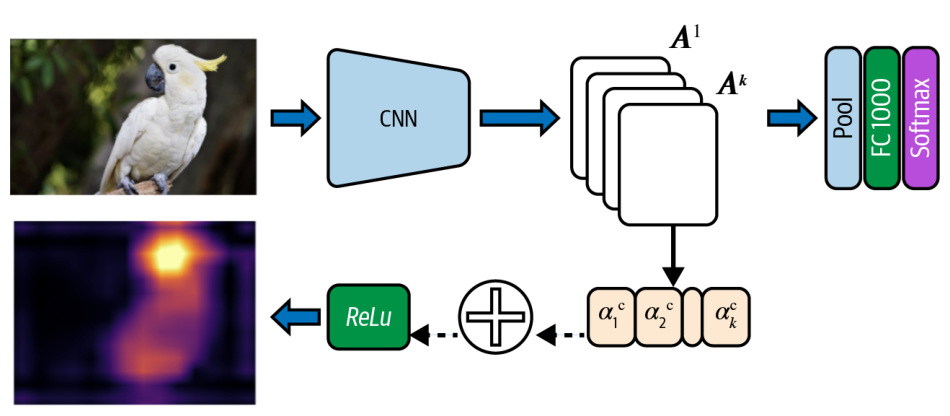

In [40]:
plt.figure(figsize=(12,8))
img=plt.imread('/content/drive/My Drive/XAI_Lab/5.png')
plt.imshow(img)
plt.axis('off')
plt.show()

### Applying Grad-CAM to Explain Model Predictions

In this section, we will apply **Grad-CAM** (Gradient-weighted Class Activation Mapping) to understand the regions of the image that influenced the model’s prediction. **Grad-CAM** is a technique that uses the gradients of the predicted class with respect to the final convolutional layer to produce a heatmap that highlights the areas of the image that were most important for the prediction.

### Steps to Apply Grad-CAM:

1. **Install the necessary package**: We will use the `tf-explain` library to apply Grad-CAM. First, make sure you have installed the library by running the following:

    ```python
    !pip install tf-explain
    ```

2. **Import the necessary module**: Import `GradCAM` from the `tf_explain` library.

    ```python
    from tf_explain.core.grad_cam import GradCAM
    ```

3. **Initialize Grad-CAM**: Instantiate the Grad-CAM object.

    ```python
    gradcam = GradCAM()
    ```

4. **Generate Grad-CAM heatmap**: Use Grad-CAM to generate a heatmap for the image. Specify the model and the target class (the predicted class) for which you want to generate the heatmap.

    ```python
    # This will generate a Grad-CAM explanation for the image
    explanation = gradcam.explain(
        validation_data=(normalized_img, None),  # Pass the image for which you want the explanation
        model=model,                            # The trained model
        class_index=exp.top_labels[0],           # The top predicted class (use `exp.top_labels[0]` from LIME)
        layer_name='block14_sepconv2_act'        # The last convolutional layer in Xception
    )
    ```

5. **Visualize the heatmap**: Grad-CAM will output a heatmap showing the areas of the image that contributed most to the model’s prediction. You can display this heatmap with the following:

    ```python
    plt.imshow(explanation[0])
    plt.axis('off')
    plt.show()
    ```



---

### Expected Outcome:
You should see a heatmap overlaid on your image, with the warm colors (typically red) indicating the most important areas for the model’s prediction. Grad-CAM will provide a more visual and localized explanation of the model’s decision.



In [41]:
!pip install tf-explain


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.9 MB/s eta 0:00:00


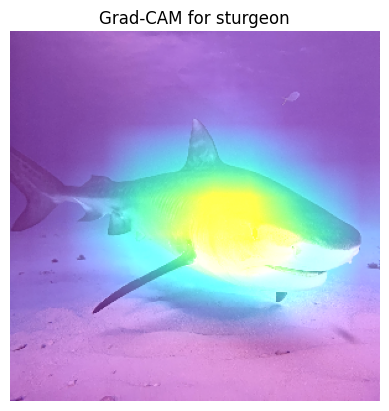

In [42]:
from tf_explain.core.grad_cam import GradCAM

# Select the layer to visualize
target_layer_name = "block14_sepconv2_act"

# Prepare input and target
input_image = normalized_img
# Decode predictions to get class names and indices

class_index = np.argmax(pred)

gradcam = GradCAM()

grid = gradcam.explain(
    validation_data=(input_image, None),
    model=model,
    class_index=class_index,  # Integer index for the target class
    layer_name=target_layer_name,
)

# Display the Grad-CAM result
plt.imshow(grid)
plt.axis('off')  # Remove axes for better visualization
plt.title(f"Grad-CAM for {pred[1]}")  # Use the predicted class name
plt.show()

### Your Turn:
Now, it's your turn to experiment with Grad-CAM! Follow these steps and apply Grad-CAM to an image of your choice. Generate the heatmap and visualize which regions of the image were most influential in the model’s prediction.

Make sure you:
- Use the same image you applied LIME to (or a new one if you prefer).
- Use the Grad-CAM method to visualize the important regions of the image.
- Compare the results from LIME and Grad-CAM to understand how both methods explain the model’s predictions.

## Reference

1. The image is taken from Imgur: https://i.imgur.com/1Phh6hv.jpeg
2. LIME Open Source Python Framework in GitHub - https://github.com/marcotcr/lime
3. Research paper on LIME - [“Why Should I Trust You?”
Explaining the Predictions of Any Classifier](https://arxiv.org/pdf/1602.04938.pdf)
4. Original blog post on LIME by the author - https://homes.cs.washington.edu/~marcotcr/blog/lime/
4. Some of the utility functions and code are taken from the GitHub Repository of the author - Aditya Bhattacharya https://github.com/adib0073